# Model to predict a tip

To suggest a tip amount to the rider I was going to produce a model based on the NY yellow taxi data.
- This data can be found here: (http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) and is described by the data dictionary (http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

## Data preparation 

In [68]:
from scipy import stats
from scipy.stats import lognorm, spearmanr, linregress
import random
import pandas as pd
import numpy as np
import datetime as dt
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pysal as ps
from pylab import figure, scatter, show
import math
import statsmodels.api as sm 
from scipy.interpolate import interp1d

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
allFiles = glob.glob("*.csv")
frame = pd.DataFrame()
list_ = []

for file_ in allFiles:
    num_lines = sum(1 for l in open(file_))
    # Sample size - in this case ~1%
    size = int(num_lines / 100)

    skip_idx = random.sample(range(1, num_lines), num_lines - size)

    df = pd.read_csv(file_, skiprows=skip_idx, index_col=None, header=0 )
    list_.append(df)
    
yellow = pd.concat(list_)

* The data for the months of March, June, and November in 2017 for Yellow Taxi is imported into the "yellow" variable.
 - Total data dimension: 29236424 rows * 17 columns
     - So, I choose only 1% of data to facilitate to see the data before make a model.
 - There is a rare value in the passenger_count like 192.
 - There are negative values in fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge and total_amount.
 - In the RatecodeID there are inappropriate values like 99.

In [3]:
yellow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292360 entries, 0 to 92846
Data columns (total 17 columns):
VendorID                 292360 non-null int64
tpep_pickup_datetime     292360 non-null object
tpep_dropoff_datetime    292360 non-null object
passenger_count          292360 non-null int64
trip_distance            292360 non-null float64
RatecodeID               292360 non-null int64
store_and_fwd_flag       292360 non-null object
PULocationID             292360 non-null int64
DOLocationID             292360 non-null int64
payment_type             292360 non-null int64
fare_amount              292360 non-null float64
extra                    292360 non-null float64
mta_tax                  292360 non-null float64
tip_amount               292360 non-null float64
tolls_amount             292360 non-null float64
improvement_surcharge    292360 non-null float64
total_amount             292360 non-null float64
dtypes: float64(8), int64(6), object(3)
memory usage: 40.1+ MB


- Accordig to the Data Dictionary – Yellow Taxi Trip Records (http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf):
 - VendorID: TPEP provider that provided the record 
         (1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.)
 - tpep_pickup_datetime / tpep_dropoff_datetime: The date and time when the meter was engaged or disengaged.
 - Passenger_count: The number of passengers in the vehicle and This is a driver-entered value.
 - Trip_distance: The elapsed trip distance in miles reported by the taximeter.
 - PULocationID / DOLocationID: PULocationID TLC Taxi Zone in which the taximeter was engaged or disengaged.
 - RateCodeID: RateCodeID The final rate code in effect at the end of the trip.
         (1= Standard rate; 2=JFK; 3=Newark; 4=Nassau or Westchester; 5=Negotiated fare; 6=Group ride)
 - Store_and_fwd_flag: whether the trip record was held in vehicle memory before sending to the vendor.
         (Y= store and forward trip = the vehicle did not have a connection to the server; N= not a store and forward trip)
 - Payment_type: how the passenger paid for the trip. 
         (1= Credit card; 2= Cash; 3= No charge; 4= Dispute; 5= Unknown; 6= Voided trip)
 - Fare_amount: The time-and-distance fare calculated by the meter.
 - Extra: the 0.5 dollar and 1 dollar rush hour and overnight charges.
 - MTA_tax: 0.5 dollar MTA tax that is automatically triggered based on the metered rate in use.
 - Improvement_surcharge: 0.3 dollar improvement surcharge assessed trips at the flag drop.
 - Tip_amount: This field is automatically populated for credit card tips. Cash tips are not included.
 - Tolls_amount: Total amount of all tolls paid in trip. 
 - Total_amount: The total amount charged to passengers. Does not include cash tips.

## Data Cleaning

In [30]:
data = yellow[(yellow['passenger_count'] < 10) & 
                        (yellow['passenger_count'] > 0) & 
                        (yellow['extra'] >= 0) &
                        (yellow['extra'] <= 1) &
                        (yellow['RatecodeID'] < 7) &
                        (yellow['mta_tax'] >= 0) &
                        (yellow['tip_amount'] >= 0) &
                        (yellow['tolls_amount'] >= 0) &
                        (yellow['improvement_surcharge'] > 0) &
                        (yellow['total_amount'] >= 0)]

data = data.replace({'store_and_fwd_flag': {'Y': 1, 'N': 0}})

data['tpep_pickup_datetime'] = data.tpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['tpep_dropoff_datetime'] = data.tpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

data['pickup_hour'] = data.tpep_pickup_datetime.apply(lambda x: x.hour)
data['pickup_day'] = data.tpep_pickup_datetime.apply(lambda x: x.weekday())
data = data.assign(duration = lambda x: ((x.tpep_dropoff_datetime-x.tpep_pickup_datetime)/ np.timedelta64(1, 'm')))


## Distribution of variables

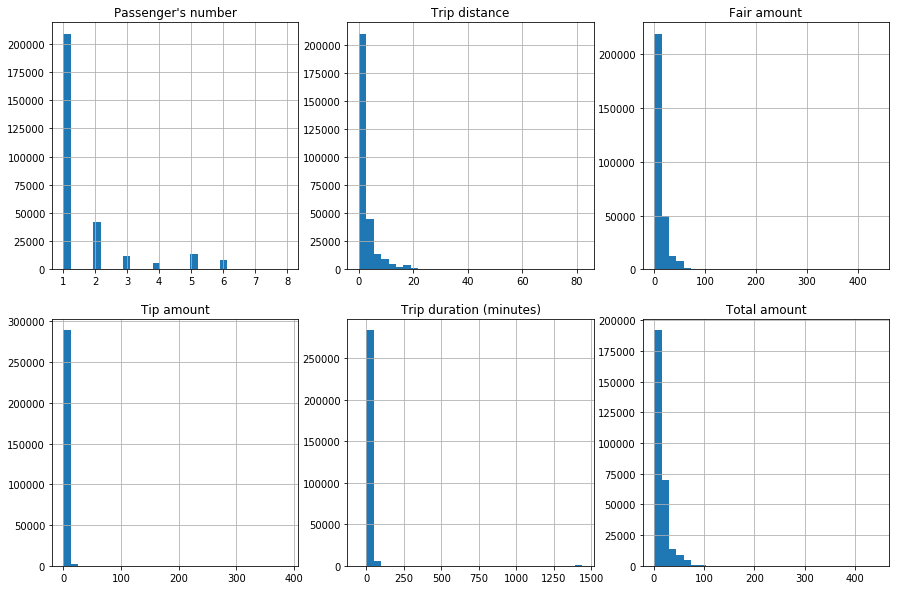

In [6]:
fig,ax = plt.subplots(2,3,figsize=(15,10))

data.passenger_count.hist(bins=30, ax=ax[0,0])
data.trip_distance.hist(bins=30, ax=ax[0,1])
data.fare_amount.hist(bins=30, ax=ax[0,2])
data.tip_amount.hist(bins=30, ax=ax[1,0])
data.duration.hist(bins=30, ax=ax[1,1])
data.total_amount.hist(bins=30, ax=ax[1,2])


ax[0,0].set_title("Passenger's number")
ax[0,1].set_title('Trip distance')
ax[0,2].set_title("Fair amount")
ax[1,0].set_title("Tip amount")
ax[1,1].set_title("Trip duration (minutes)")
ax[1,2].set_title("Total amount")


plt.show()

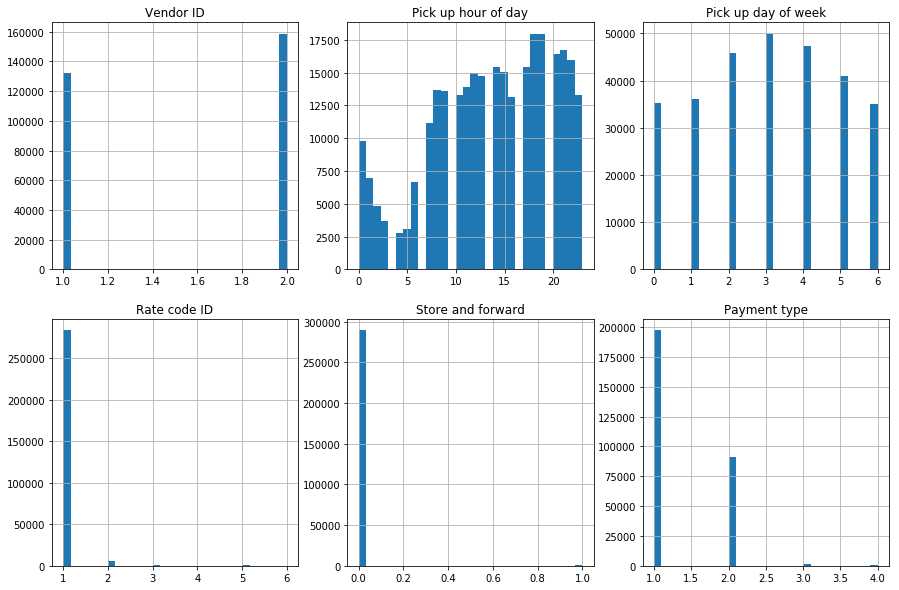

In [7]:
fig,ax = plt.subplots(2,3,figsize=(15,10))

data.VendorID.hist(bins=30, ax=ax[0,0])
data.pickup_hour.hist(bins=30, ax=ax[0,1])
data.pickup_day.hist(bins=30, ax=ax[0,2])
data.RatecodeID.hist(bins=30, ax=ax[1,0])
data.store_and_fwd_flag.hist(bins=30, ax=ax[1,1])
data.payment_type.hist(bins=30, ax=ax[1,2])



ax[0,0].set_title("Vendor ID")
ax[0,1].set_title("Pick up hour of day")
ax[0,2].set_title("Pick up day of week")
ax[1,0].set_title("Rate code ID")
ax[1,1].set_title("Store and forward")
ax[1,2].set_title("Payment type")

plt.show()

- The VeriFone Inc. is occupied a litter more than CMT.
- The most trip is in the standard rate.
- The most trip record is on the connection to the server.
- In the payment way a credit card is the most useage and then cash payment.

The tip amount data is only based on the credit card payment. When they paid by the other ways we could not see how much paid for a tip and in the data that indicate 0. So, these zero data are not vaild for this analysis. Also, I made a new column "before_tip" that was presented an amount of trip cost to a rider before pay a tip.

In [31]:
tip_data = data[(data['payment_type'] == 1)]
tip_data = tip_data.drop(['payment_type'], axis=1)
tip_data = tip_data.assign(before_tip = lambda x: (x.total_amount-x.tip_amount))

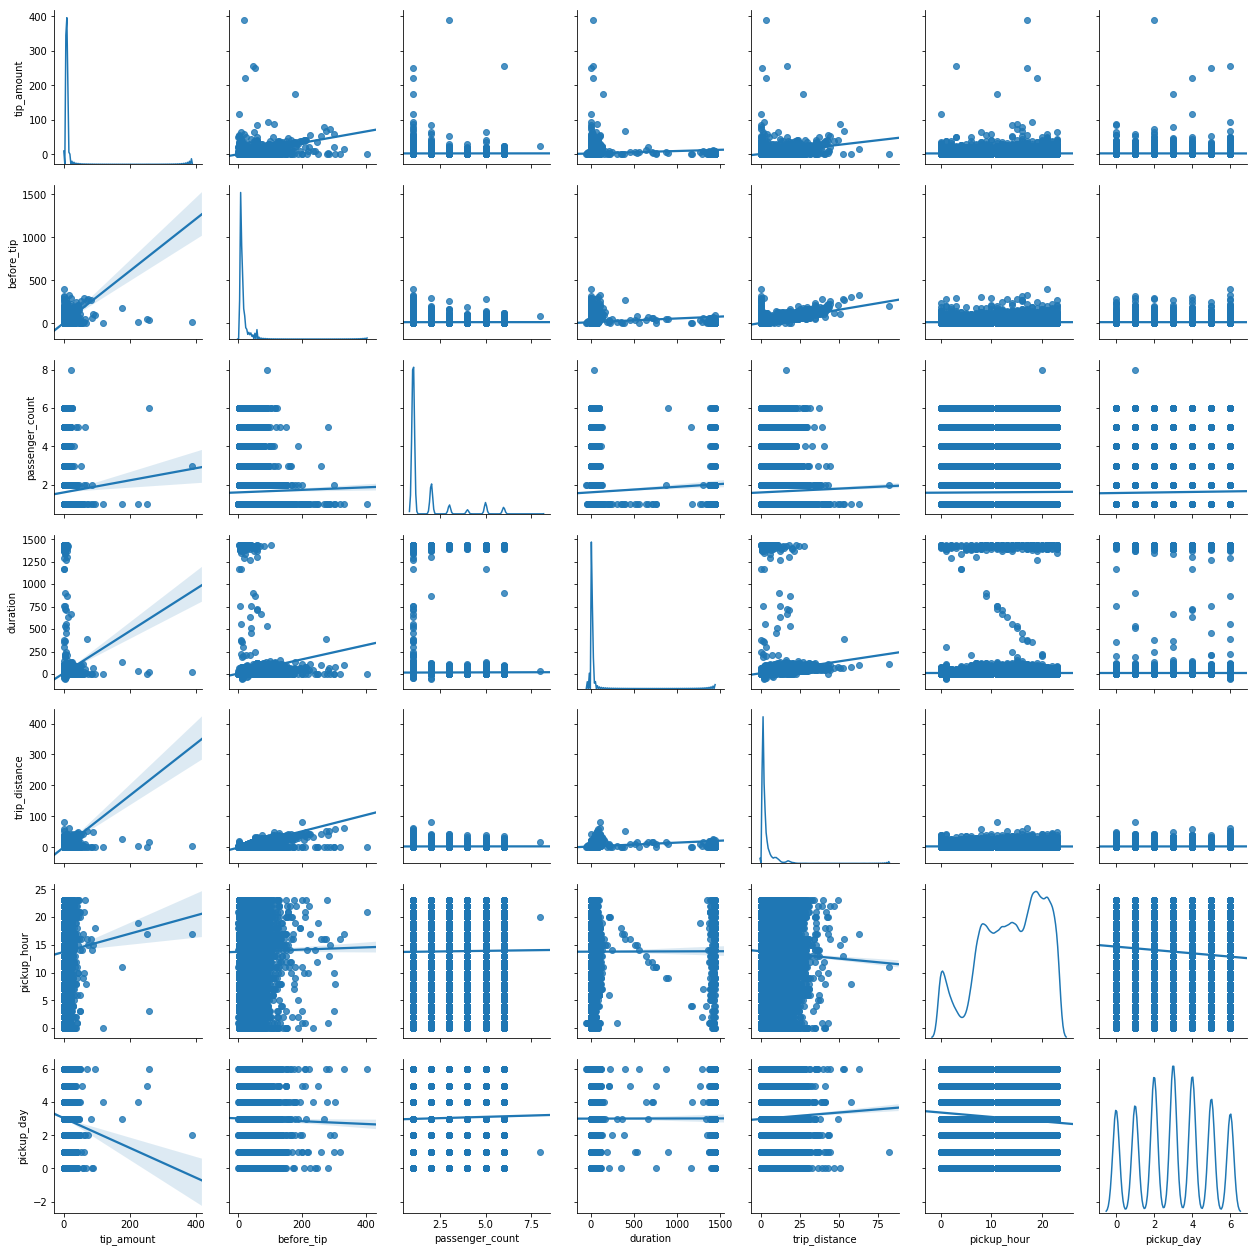

In [9]:
sns.pairplot(tip_data, 
             vars=['tip_amount','before_tip','passenger_count','duration','trip_distance','pickup_hour','pickup_day'], 
             diag_kind="kde", kind="reg")

plt.show()

- Tip amount has relation with total amount before pay a tip. 

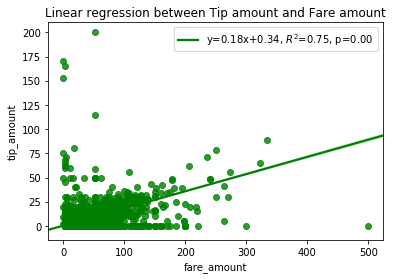

In [13]:

slope, intercept, r_value, p_value, std_err = stats.linregress(tip_data['fare_amount'],tip_data['tip_amount'])

# use line_kws to set line label for legend
ax = sns.regplot(x="fare_amount", y="tip_amount", data=tip_data, color='g', 
 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,intercept,r_value,p_value)})

# plot legend
ax.legend()
ax.set_title("Linear regression between Tip amount and Fare amount")
plt.show()

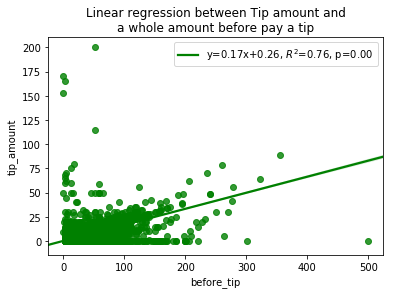

In [14]:

slope, intercept, r_value, p_value, std_err = stats.linregress(tip_data['before_tip'],tip_data['tip_amount'])

# use line_kws to set line label for legend
ax = sns.regplot(x="before_tip", y="tip_amount", data=tip_data, color='g', 
 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,intercept,r_value,p_value)})

# plot legend
ax.legend()
ax.set_title("""Linear regression between Tip amount and
a whole amount before pay a tip""")

plt.show()

As seen the above plots, a tip amount is highly related with a fair amount and a whole amount before pay a tip. Curiously, it looks like passengers pay more a tip when they should pay more for a trip. So, I added a new column named "tip_percentage".
- tip_percentage_1: a portion of a fare amount
- tip_percentage_2: a portion of a whole amount before pay a tip

Also, I made a new column to indicate which trip had had a tip. (0: no paid a tip; 1: paid a tip)

In [32]:
tip_data = tip_data.assign(tip_percentage_1 = lambda x: (x.tip_amount/x.fare_amount)*100)
tip_data = tip_data.assign(tip_percentage_2 = lambda x: (x.tip_amount/(x.before_tip))*100)

In [33]:
tip_data['tip_no_paid'] = tip_data.tip_amount.isin([0]).astype(np.int64)

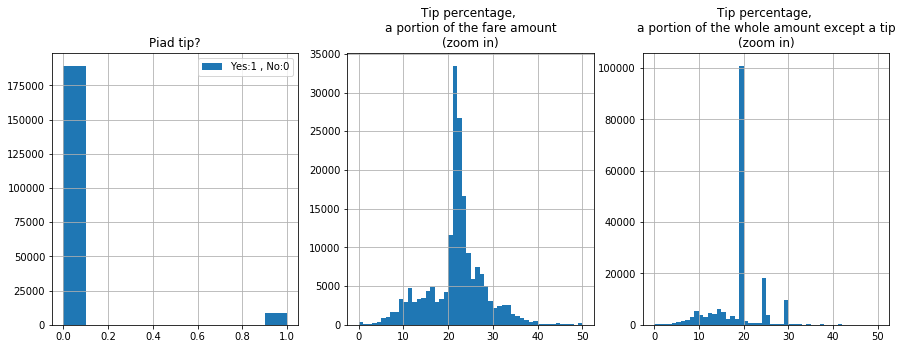

In [17]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
tip_data.tip_no_paid.hist(ax=ax[0])
tip_data.tip_percentage_1[(tip_data['tip_percentage_1'] <=50)&(tip_data['tip_no_paid'] == 0)].hist(bins=50,ax=ax[1])

tip_data.tip_percentage_2[(tip_data['tip_percentage_2'] <=50)&(tip_data['tip_no_paid'] == 0)].hist(bins=50,ax=ax[2])

ax[0].set_title("Piad tip?")
ax[0].legend(['Yes:1 , No:0'])
ax[1].set_title("""Tip percentage, 
a portion of the fare amount
(zoom in)""")

ax[2].set_title("""Tip percentage, 
a portion of the whole amount except a tip
(zoom in)""")

plt.show()

The most passenger paid a tip. The distribution of tip percentage that was calculated by a portion of the fare amount seems a unimodal concentrated. 
However when we calculated a tip percentage by a portion of the total amount pay except a tip, we can see three picks, 20%, 25% and 30%.

- It looks like many passengers seem to make a defalt choice among the three option before pay a tip.
- According to the [https://www.youtube.com/watch?v=qdTtbc2-zeU] there are options to pay a tip in this case there are three buttons. So, depanding on the programe that is representing to passenger to pay a tip, the distribution of tip percentage and tip amount would be changed dramatically for example, if the screen offers a blank option to pay a tip for dollar or only two options.
- The most passengers pay a tip selecting among the three options. I think that is easy to pay a tip, if they would not want that they sholud push the other button and put a tip amount on purpose. As thinking generally people look for a taxi when they do not have a time, selecting among the options to pay a tip is such easy way. 

In [209]:
tip_select = tip_data[(tip_data['tip_no_paid'] == 0)]

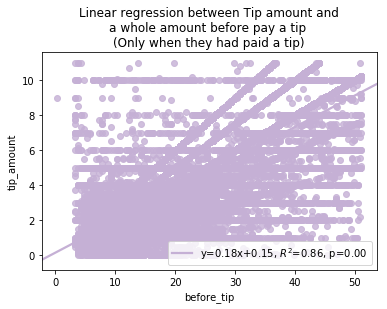

In [296]:
tip_select_ = tip_select[(np.abs(stats.zscore(tip_select[['tip_amount','before_tip']]))<3).all(axis=1)]


slope, intercept, r_value, p_value, std_err = stats.linregress(tip_select_['before_tip'],tip_select_['tip_amount'])
ax = sns.regplot(x="before_tip", y="tip_amount", data=tip_select_, color='#c5b0d5',
 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,intercept,r_value,p_value)})
ax.legend()
ax.set_title("""Linear regression between Tip amount and
a whole amount before pay a tip 
(Only when they had paid a tip)""")

plt.show()

When we focus on when passengers had paid a tip, they paid about 18% of a whole amount before pay a tip. In the above graph we could observe 5 diagonal lines (10, 15, 20, 25, 30%) and these lines indicate a tendency of tip percentage.

So, what's different after eliminating the effect of the defalt options (20, 25, 30%)? 
I made a new variable "tip_decision" to see how much pay a tip when passengers would be going to pay a tip but not just select among three options.

In [35]:
tip_decision = tip_data[(tip_data['tip_no_paid'] == 0)^
                        ((tip_data['tip_percentage_2'].round() ==20)|
                         (tip_data['tip_percentage_2'].round() ==25)|(tip_data['tip_percentage_2'].round() ==30))]

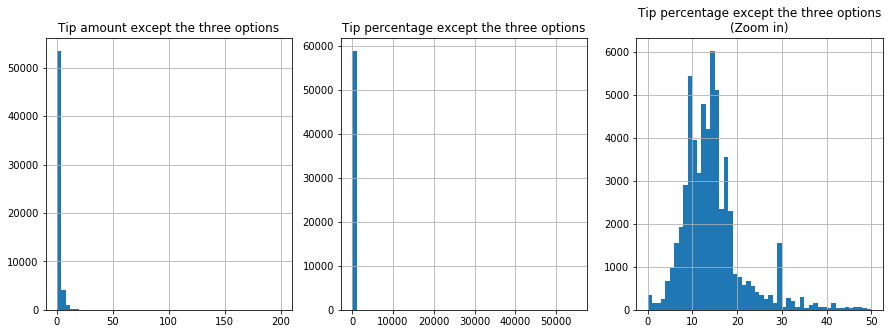

In [259]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

tip_decision.tip_percentage_2.hist(bins=50, ax=ax[1])
tip_decision.tip_amount.hist(bins=50, ax=ax[0])
tip_decision.tip_percentage_2[tip_decision['tip_percentage_2'] < 50].hist(bins=50, ax=ax[2])

ax[1].set_title("Tip percentage except the three options")
ax[2].set_title("""Tip percentage except the three options
(Zoom in)""")
ax[0].set_title("Tip amount except the three options")

plt.show()

- After eliminate the three defalt options there is a slice tendency to select a tip amount like 15%, 10% or 18%.

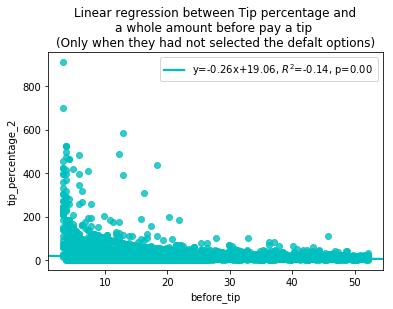

In [267]:
tip_decision_ = tip_decision[(np.abs(stats.zscore(tip_decision[['tip_percentage_2','before_tip']]))<3).all(axis=1)]


slope, intercept, r_value, p_value, std_err = stats.linregress(tip_decision_['before_tip'],tip_decision_['tip_percentage_2'])

# use line_kws to set line label for legend
ax = sns.regplot(x="before_tip", y="tip_percentage_2", data=tip_decision_, color='c', 
 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,intercept,r_value,p_value)})

# plot legend
ax.legend()
ax.set_title("""Linear regression between Tip percentage and
a whole amount before pay a tip 
(Only when they had not selected the defalt options)""")

plt.show()

- After eliminate the three defalt options, a tip percentage has a negative relationship with whole amount cost before pay a tip. 

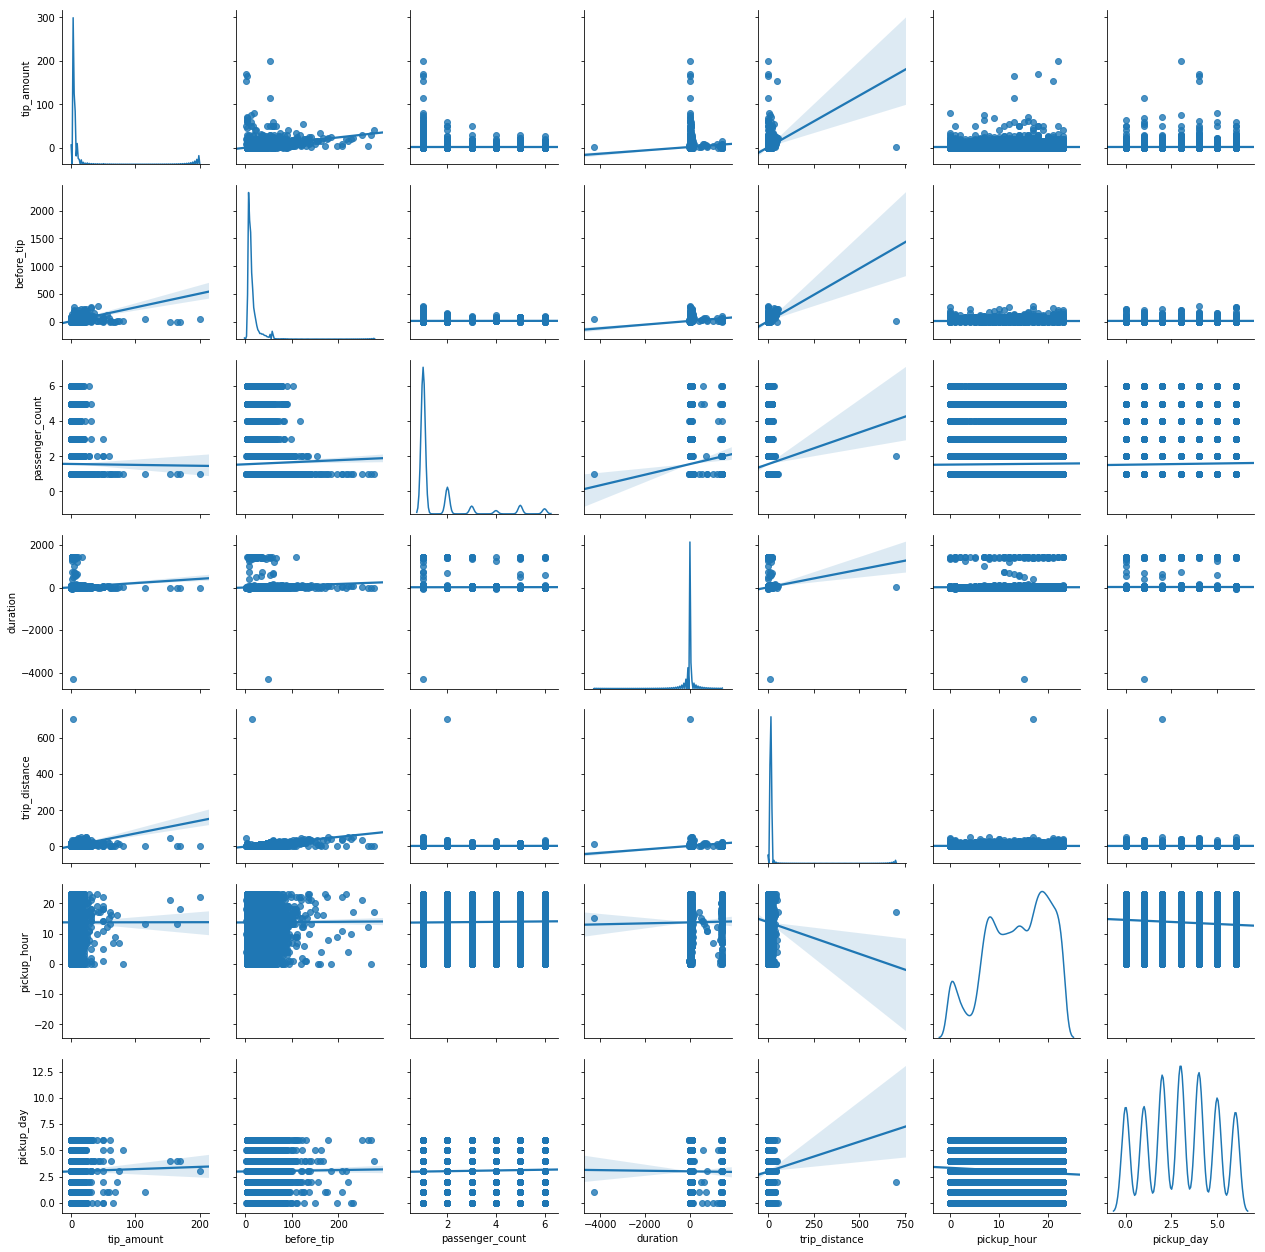

In [37]:
sns.pairplot(tip_decision, 
             vars=['tip_amount','before_tip','passenger_count','duration','trip_distance','pickup_hour','pickup_day'], 
             diag_kind="kde", kind="reg")

plt.show()


- When the three defalt options (20, 25, 30%) were eliminated there is a relationship between tip ampiunt and the other variable - before trip: a whole amount before pay a tip, trip distance and trip duration -.  

In [39]:
lowess = sm.nonparametric.lowess
# farc = neighborhood size, it= number of iterations 
w = lowess(tip_decision['tip_amount'], tip_decision['before_tip'], frac=0.1,it=1)


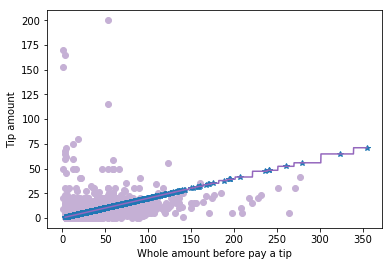

In [283]:
#### # unpack the lowess smoothed points to their values
lowess_x = list(zip(*w))[0]
lowess_y = list(zip(*w))[1]

# run scipy's interpolation. 
f = interp1d(lowess_x, lowess_y, bounds_error=False, kind= 'nearest')

xnew = [i/10. for i in range(4000)]
ynew = f(xnew)


plt.plot(tip_decision['before_tip'], tip_decision['tip_amount'],  'o', c="#c5b0d5")
plt.plot(lowess_x, lowess_y, '*')
plt.plot(xnew, ynew, '-',c="#9467bd")

plt.xlabel("Whole amount before pay a tip")
plt.ylabel("Tip amount")
plt.show()

- Passenger who did want to pay a tip but not to select among three options (20, 25, 30%) generally paid more a tip as a whole amount increasing. Although some pessenger wanted pay a huge tip, generally they'd like to pay under 25 dollar.

## Applied ML with Linear Regression

Until now, I treated only 1% of data. So, I will going to make a linear model to suggest a tip amount when the passenger do not want to pay among the defalt options.

In [48]:
allFiles = glob.glob("*.csv")
frame = pd.DataFrame()
list_ = []

for file_ in allFiles:
    num_lines = sum(1 for l in open(file_))

    df = pd.read_csv(file_, header=0, usecols=['tip_amount', 'total_amount', 'trip_distance','payment_type',
                                              'tpep_dropoff_datetime','tpep_pickup_datetime'])
    list_.append(df)
    
df = pd.concat(list_)

In [49]:
df['tpep_pickup_datetime'] = df.tpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
df['tpep_dropoff_datetime'] = df.tpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

df = df[(df['payment_type'] == 1)]

df['tip_no_paid'] = df.tip_amount.isin([0]).astype(np.int64)

df = df.assign(before_tip = lambda x: (x.total_amount-x.tip_amount))
df = df.assign(tip_percentage_2 = lambda x: (x.tip_amount/(x.total_amount-x.tip_amount))*100)
df = df.assign(trip_duration = lambda x: ((x.tpep_dropoff_datetime-x.tpep_pickup_datetime)/ np.timedelta64(1, 'm')))

In [218]:
new_df = df[(df['tip_no_paid'] == 0)^
            ((df['tip_percentage_2'].round() ==20)|(df['tip_percentage_2'].round() ==25)|(df['tip_percentage_2'].round() ==30))]

In [219]:
new_df['log_tip_amount'] =new_df.tip_amount.apply(np.log)

new_df['log_before_tip'] = new_df.before_tip.apply(np.log)


new_df = new_df[['log_tip_amount','log_before_tip']]
new_df = new_df.rename(index=str, columns={"log_tip_amount": "tip_amount"})

In [220]:
new_df = new_df.replace([np.inf, -np.inf], np.nan).dropna()
new_df = new_df[(np.abs(stats.zscore(new_df[['tip_amount','log_before_tip']]))<3).all(axis=1)]


- I tried a log transformation due to a positively skewed data and eliminated outliers.

In [221]:
#filtering the dataframe to include just the IV's (features) and another with just the DV's (target)
features = new_df.loc[:,new_df.columns != 'tip_amount']
targets = new_df.loc[:,new_df.columns == 'tip_amount']

#splitting our dataset randomly with the test data containing 10% of the data,
X_train, X_test, y_train, y_test = train_test_split(features,targets, 
                                                    test_size=0.1, 
                                                    random_state=42)

#view number of training and testing data
print('Our training prediction variable contains :',len(y_train) ,'rows')
print('Our training independent variable contains :',len(X_train) ,'rows')
print('Our testing prediction variable contains :',len(y_test) ,'rows')
print('Our testing independent variable contains :',len(X_test) ,'rows')

Our training prediction variable contains : 5244196 rows
Our training independent variable contains : 5244196 rows
Our testing prediction variable contains : 582689 rows
Our testing independent variable contains : 582689 rows


In [222]:
#Instantiate the regression model and setting parameters if any,
reg_model = LinearRegression()

#fitting the training data to the model,
reg_model.fit(X_train, y_train)

#outputs the coefficients
print('Intercept :', reg_model.intercept_[0], '\n')
print(pd.DataFrame({'features':X_train.columns,'coeficients':reg_model.coef_[0]}))
#outputs the training and testing scores
print("Training set score: {:.2f}".format(reg_model.score(X_train, y_train)))

Intercept : -1.3656788948000544 

         features  coeficients
0  log_before_tip     0.746064
Training set score: 0.50


In [224]:
cv_reg_model = LinearRegression()
cv_scores = cross_val_score(cv_reg_model, features, targets,cv=100, scoring='r2')

#outputs the scores
print("\nAverage 100-Fold CV Score: {}".format(np.mean(cv_scores)))

Cross Validation scores: [0.45775534 0.49642566 0.47289014 0.48953662 0.47286831 0.41864079
 0.4115508  0.5268455  0.50717156 0.47998002 0.47469823 0.49094029
 0.49713411 0.48970009 0.50354323 0.54454943 0.40819931 0.49718261
 0.5115802  0.51432495 0.45295526 0.45269531 0.53822151 0.52091685
 0.49610203 0.47522366 0.47325859 0.49759961 0.50004886 0.47352381
 0.51025279 0.49086804 0.49477666 0.4792292  0.4740282  0.44276046
 0.47585842 0.47539897 0.4896601  0.45382648 0.48815661 0.5296738
 0.47573686 0.45862186 0.48402104 0.51273639 0.50011191 0.48918768
 0.49725615 0.50058616 0.50134201 0.44815979 0.48737701 0.52718372
 0.4989405  0.49254709 0.5014044  0.50022076 0.49744474 0.46528257
 0.44981145 0.55497389 0.50890845 0.50358853 0.53277717 0.53796906
 0.54660529 0.51226993 0.52242839 0.49647178 0.50545274 0.48151127
 0.43100281 0.53051617 0.53679019 0.48423237 0.50778847 0.51428855
 0.48235064 0.45481891 0.43732135 0.56028829 0.52154326 0.50824029
 0.51285812 0.50657711 0.49120117 0.47

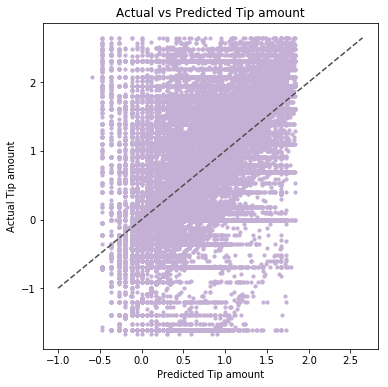

In [278]:
#prediction values using testing set
y_pred = reg_model.predict(X_test)

y_pred_a = pd.DataFrame(y_pred)
y_test_a = y_test.reset_index(drop=True, inplace=False)
pred_act_df = pd.concat([y_test_a,y_pred_a], axis=1).sort_values(1,axis=1).reset_index(drop=True)

#output samples of our predicted values
plt.figure(figsize=(6, 6))
maxlimit = pred_act_df['tip_amount'].max()

plt.scatter(pred_act_df[0], pred_act_df['tip_amount'], s=10, c="#c5b0d5")
plt.xlabel('Predicted Tip amount')
plt.ylabel('Actual Tip amount')
plt.plot([-1,maxlimit], [-1,maxlimit], ls="--", c=".3")
plt.title('Actual vs Predicted Tip amount')
plt.show()

In [227]:
#for calculating MSE
y_pred_test = reg_model.predict(X_test)
y_pred_train = reg_model.predict(X_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print("Root Mean Squared Error of Training Set: {}".format(rmse_train))
print("Root Mean Squared Error of Testing Set: {}".format(rmse_test))

Root Mean Squared Error of Training Set: 0.43837789554147805
Root Mean Squared Error of Testing Set: 0.43802395636679736


In [228]:
#training the OLS algorithm and outputting the summary statistics
X_train_sm = sm.add_constant(X_train)
sm_train_model = sm.OLS(y_train, X_train_sm).fit()
print(sm_train_model.summary())
print(sm_train_model.rsquared_adj)

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                 5.148e+06
Date:                Mon, 10 Sep 2018   Prob (F-statistic):               0.00
Time:                        09:41:52   Log-Likelihood:            -3.1164e+06
No. Observations:             5244196   AIC:                         6.233e+06
Df Residuals:                 5244194   BIC:                         6.233e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.3657      0.001  -1630.

In [226]:
#re-run OLS model as sm_model using training and testing dataset,
X_train_sm = sm.add_constant(X_train)
sm_train_model = sm.OLS(y_train, X_train_sm).fit()
print('Training set adj r2: {}'.format(sm_train_model.rsquared_adj))

#run CV again and loop through results applying adjusted r2 formula. Output the results
cv_scores_r2 = cross_val_score(cv_reg_model, features, targets,cv=100, scoring='r2')
cv_scores_adj = []
n = len(features)
k = len(features.columns)
for r in cv_scores_r2:
    adj_r2 = 1-(((1-r)*(n-1))/(n-k-1))
    cv_scores_adj.append(adj_r2)
print('Average 100-Fold CV adj r2: {}'.format(np.mean(cv_scores_adj)))

Training set adj r2: 0.49539505082345214
Average 100-Fold CV adj r2: 0.4929496257706264


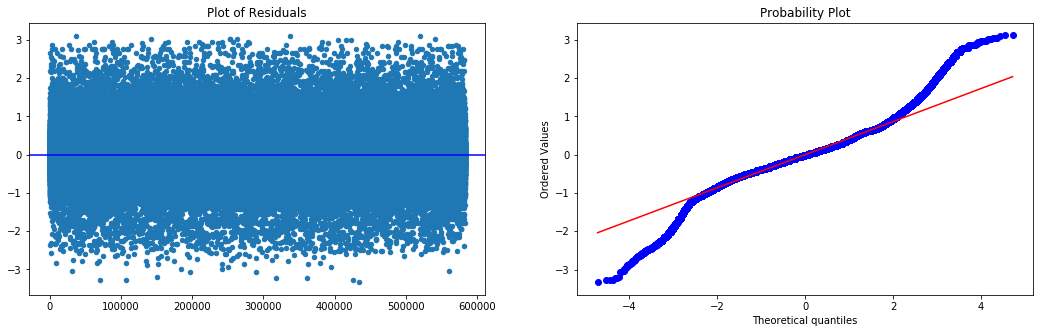

In [229]:
#calculate the residuals
y_pred = pd.DataFrame(y_pred)
y_test = y_test.reset_index(drop=True)
residuals = y_test.tip_amount - y_pred[0]

#plotting Residual and Probabililty graph
plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
plt.axhline(0, color="blue")
plt.title('Plot of Residuals')
plt.scatter(residuals.index,residuals, s=20)

plt.subplot(1,2,2)
plt.title('Probability Plot')
stats.probplot(residuals, dist='norm',plot=plt)
plt.show()

- The equation of the linear model to predict a tip amount is:

log(*tip_amount*) = - 1.3657  + 0.7461 log(*whole amount before pay a tip*)


- This model could be close the data about 50%.

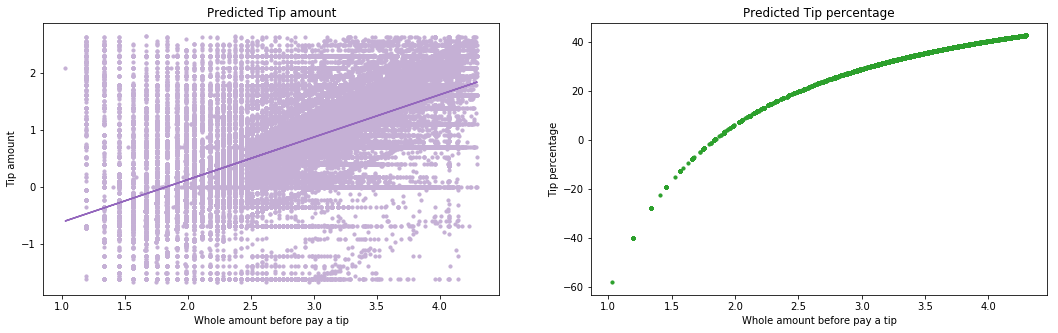

In [277]:
plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
y_pred = reg_model.predict(X_test)
plt.plot(X_test,y_pred, color="#9467bd")
plt.scatter(X_test, y_test, s=10, c="#c5b0d5")
plt.xlabel('Whole amount before pay a tip')
plt.ylabel('Tip amount')
plt.title('Predicted Tip amount')

plt.subplot(1,2,2)
y_pred_pc = (y_pred/X_test)*100
y_pred_pc = y_pred_pc.rename(index=str, columns={"log_before_tip": "tip_percentage"})
plt.scatter(X_test, y_pred_pc, s=10, c="#2ca02c")
plt.xlabel('Whole amount before pay a tip')
plt.ylabel('Tip percentage')
plt.title('Predicted Tip percentage')

plt.show()